In [65]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim, device
from torch.utils.data import TensorDataset, DataLoader

In [66]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


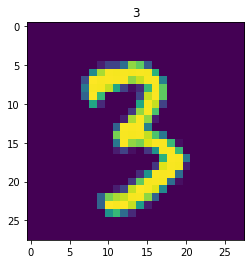

In [67]:
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[200, 0])
plt.title(data_y[200])
plt.show()

In [68]:
for pics in data_x:
    pics=transform(pics)

In [69]:
#split for training and test data
train_x=data_x[:16000]
train_y=data_y[:16000]

test_x=data_x[16000:]
test_y=data_y[16000:]
print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

(16000, 1, 28, 28) (16000,)
(4000, 1, 28, 28) (4000,)


In [70]:
#Create the DataLoaders
tensor_x = torch.Tensor(train_x)
tensor_y = torch.Tensor(train_y)

val_tensor_x=torch.Tensor(test_x)
val_tensor_y=torch.Tensor(test_y)

#Cast into LongTensors for the label Tensors
tensor_y=tensor_y.type(torch.LongTensor) 
val_tensor_y=val_tensor_y.type(torch.LongTensor)

train_set = TensorDataset(tensor_x,tensor_y) # create your datsets
test_set= TensorDataset(val_tensor_x,val_tensor_y)

trainloader = DataLoader(train_set,batch_size=64,shuffle=True)

valloader= DataLoader(test_set,batch_size=100,shuffle=True)

In [75]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


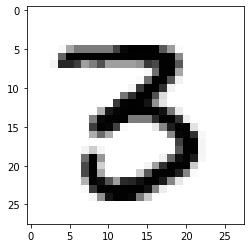

In [76]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

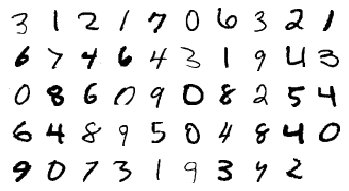

In [77]:
figure = plt.figure()
num_of_images = 49
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [78]:
#define the model

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [55]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [56]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [57]:
#training process
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5662152975797653
Epoch 1 - Training loss: 0.21486641898751258
Epoch 2 - Training loss: 0.1517160995863378
Epoch 3 - Training loss: 0.12169833443313836
Epoch 4 - Training loss: 0.08625818163715303
Epoch 5 - Training loss: 0.06868209540098906
Epoch 6 - Training loss: 0.06419678558735177
Epoch 7 - Training loss: 0.04881671347329393
Epoch 8 - Training loss: 0.031227063265163453
Epoch 9 - Training loss: 0.019684218761976808
Epoch 10 - Training loss: 0.016422315040254033
Epoch 11 - Training loss: 0.011017664890736342
Epoch 12 - Training loss: 0.006243453833390958
Epoch 13 - Training loss: 0.006072430133994203
Epoch 14 - Training loss: 0.0032264418568229303

Training Time (in minutes) = 0.12217135429382324


In [60]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784) 

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
#view_classify(img.view(1, 28, 28), ps)

Predicted Digit = 7


NameError: name 'view_classify' is not defined

In [59]:
#testing process
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 4000

Model Accuracy = 0.963


In [708]:
#torch.save(model, './my_mnist_model.pt') 

In [385]:
#not finished yet
import numpy as np

prediction = # THAT'S YOUR JOB

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)

SyntaxError: invalid syntax (<ipython-input-385-9b24063c3001>, line 3)